In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class _conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias):
        super(_conv, self).__init__(in_channels = in_channels, out_channels = out_channels, 
                               kernel_size = kernel_size, stride = stride, padding = (kernel_size) // 2, bias = True)
        
        self.weight.data = torch.normal(torch.zeros((out_channels, in_channels, kernel_size, kernel_size)), 0.02)
        self.bias.data = torch.zeros((out_channels))
        
        for p in self.parameters():
            p.requires_grad = True
        

class conv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, BN = False, act = None, stride = 1, bias = True):
        super(conv, self).__init__()
        m = []
        m.append(_conv(in_channels = in_channel, out_channels = out_channel, 
                               kernel_size = kernel_size, stride = stride, padding = (kernel_size) // 2, bias = True))
        
        if BN:
            m.append(nn.BatchNorm2d(num_features = out_channel))
        
        if act is not None:
            m.append(act)
        
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        out = self.body(x)
        return out
        
class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size, act = nn.ReLU(inplace = True), bias = True):
        super(ResBlock, self).__init__()
        m = []
        m.append(conv(channels, channels, kernel_size, BN = True, act = act))
        m.append(conv(channels, channels, kernel_size, BN = True, act = None))
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        res = self.body(x)
        res += x
        return res
    
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_res_block, act = nn.ReLU(inplace = True)):
        super(BasicBlock, self).__init__()
        m = []
        
        self.conv = conv(in_channels, out_channels, kernel_size, BN = False, act = act)
        for i in range(num_res_block):
            m.append(ResBlock(out_channels, kernel_size, act))
        
        m.append(conv(out_channels, out_channels, kernel_size, BN = True, act = None))
        
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        res = self.conv(x)
        out = self.body(res)
        out += res
        
        return out
        
class Upsampler(nn.Module):
    def __init__(self, channel, kernel_size, scale, act = nn.ReLU(inplace = True)):
        super(Upsampler, self).__init__()
        m = []
        m.append(conv(channel, channel * scale * scale, kernel_size))
        m.append(nn.PixelShuffle(scale))
    
        if act is not None:
            m.append(act)
        
        self.body = nn.Sequential(*m)
    
    def forward(self, x):
        out = self.body(x)
        return out

class discrim_block(nn.Module):
    def __init__(self, in_feats, out_feats, kernel_size, act = nn.LeakyReLU(inplace = True)):
        super(discrim_block, self).__init__()
        m = []
        m.append(conv(in_feats, out_feats, kernel_size, BN = True, act = act))
        m.append(conv(out_feats, out_feats, kernel_size, BN = True, act = act, stride = 2))
        self.body = nn.Sequential(*m)
        
    def forward(self, x):
        out = self.body(x)
        return out

In [ ]:
import torch
import torch.nn as nn


class Generator(nn.Module):
    
    def __init__(self, img_feat = 3, n_feats = 64, kernel_size = 3, num_block = 16, act = nn.PReLU(), scale=4):
        super(Generator, self).__init__()
        
        self.conv01 = conv(in_channel = img_feat, out_channel = n_feats, kernel_size = 9, BN = False, act = act)
        
        resblocks = [ResBlock(channels = n_feats, kernel_size = 3, act = act) for _ in range(num_block)]
        self.body = nn.Sequential(*resblocks)
        
        self.conv02 = conv(in_channel = n_feats, out_channel = n_feats, kernel_size = 3, BN = True, act = None)
        
        if(scale == 4):
            upsample_blocks = [Upsampler(channel = n_feats, kernel_size = 3, scale = 2, act = act) for _ in range(2)]
        else:
            upsample_blocks = [Upsampler(channel = n_feats, kernel_size = 3, scale = scale, act = act)]

        self.tail = nn.Sequential(*upsample_blocks)
        
        self.last_conv = conv(in_channel = n_feats, out_channel = img_feat, kernel_size = 3, BN = False, act = nn.Tanh())
        
    def forward(self, x):
        
        x = self.conv01(x)
        _skip_connection = x
        
        x = self.body(x)
        x = self.conv02(x)
        feat = x + _skip_connection
        
        x = self.tail(feat)
        x = self.last_conv(x)
        
        return x, feat
    
class Discriminator(nn.Module):
    
    def __init__(self, img_feat = 3, n_feats = 64, kernel_size = 3, act = nn.LeakyReLU(inplace = True), num_of_block = 3, patch_size = 96):
        super(Discriminator, self).__init__()
        self.act = act
        
        self.conv01 = conv(in_channel = img_feat, out_channel = n_feats, kernel_size = 3, BN = False, act = self.act)
        self.conv02 = conv(in_channel = n_feats, out_channel = n_feats, kernel_size = 3, BN = False, act = self.act, stride = 2)
        
        body = [discrim_block(in_feats = n_feats * (2 ** i), out_feats = n_feats * (2 ** (i + 1)), kernel_size = 3, act = self.act) for i in range(num_of_block)]    
        self.body = nn.Sequential(*body)
        
        self.linear_size = ((patch_size // (2 ** (num_of_block + 1))) ** 2) * (n_feats * (2 ** num_of_block))
        
        tail = []
        
        tail.append(nn.Linear(self.linear_size, 1024))
        tail.append(self.act)
        tail.append(nn.Linear(1024, 1))
        tail.append(nn.Sigmoid())
        
        self.tail = nn.Sequential(*tail)
        
        
    def forward(self, x):
        
        x = self.conv01(x)
        x = self.conv02(x)
        x = self.body(x)        
        x = x.view(-1, self.linear_size)
        x = self.tail(x)
        
        return x

In [ ]:
generator = Generator(img_feat = 3, n_feats = 64, kernel_size = 3, num_block = 16).to('cpu')
generator.load_state_dict(torch.load("/content/drive/MyDrive/SRGAN/SRResNet.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
a = Image.open("/content/drive/MyDrive/Minor/webpage/dl_model/data/train/old_images/000001.jpg")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), Image.BICUBIC),
])
input_image = transform(a)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


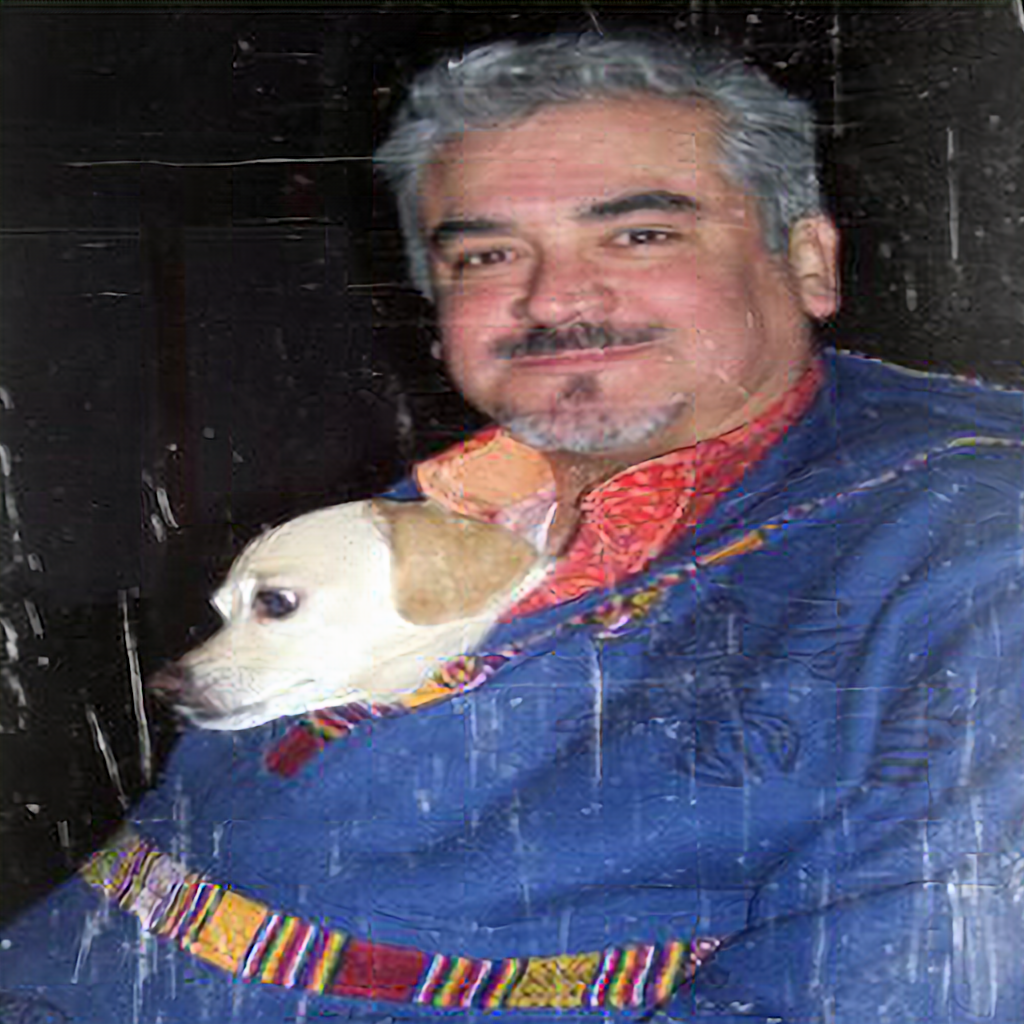

In [ ]:
import numpy as np
def np_to_pil(img_np):
    """
        Converts np.ndarray to Image.Image object
    """
    ar = np.clip(img_np * 255, 0, 255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

np_to_pil(generator(input_image.unsqueeze(0))[0][0].detach().cpu().numpy())

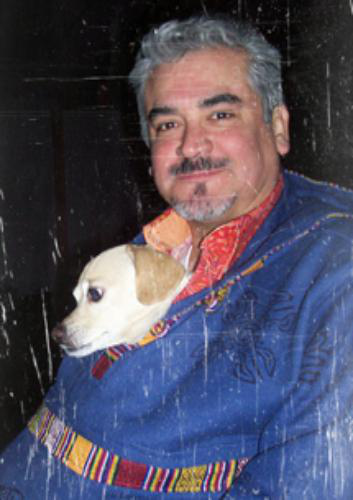

In [ ]:
a